In [36]:
import pandas as pd
import os
import pathlib
import hashlib
from collections import defaultdict
from PIL import Image, UnidentifiedImageError
import shutil
import numpy as np
from torchvision import transforms
from tqdm import tqdm
from PIL import Image, ImageFilter
import random
import torch
from torchvision.transforms import functional as F
import gc
import shutil
import math
import uuid, random
import cv2
from PIL import Image
import torchvision.transforms.functional as F

# Exploratory Data Analysis

In [2]:
data = pd.read_csv("sports.csv")
data.head()

,class id,filepaths,labels,data set
0,0,train/air hockey/001.jpg,air hockey,train
1,0,train/air hockey/002.jpg,air hockey,train
2,0,train/air hockey/003.jpg,air hockey,train
3,0,train/air hockey/004.jpg,air hockey,train
4,0,train/air hockey/005.jpg,air hockey,train


For this project we have the following data:
- train, valid, test folders: Each of them contains folders corresponding of different sports. Each of these folders conatins .jpg files of its corresponding sport
- sports.csv: It contains all previous data information. Each row tells information (label, filepath and data set) about each .jpg

We are going to do a further inspection on this csv.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14493 entries, 0 to 14492
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   class id   14493 non-null  int64 
 1   filepaths  14493 non-null  object
 2   labels     14493 non-null  object
 3   data set   14493 non-null  object
dtypes: int64(1), object(3)
memory usage: 453.0+ KB


Here we can see that we have no null a priory. However, we are going to see if there is any incosistency with this information and the data in our folders.

In [4]:
base_path = r'C:\Users\maria\OneDrive\Escritorio\ADRI\Q7 (Erasmus)\Introduction to Neural Networks\Neural_Networks\SportsClassification'
for row in data.itertuples():
    sub_path = row.filepaths 
    filepath = os.path.join(base_path, sub_path)
    if not os.path.exists(filepath):
        print(f'{filepath} not exists')
        break

C:\Users\maria\OneDrive\Escritorio\ADRI\Q7 (Erasmus)\Introduction to Neural Networks\Neural_Networks\SportsClassification\train/high jump/159.lnk not exists


We see there is not  any inconsistency as there was no prints in the code before.

In [5]:
data.labels.unique()

array(['air hockey', 'ampute football', 'archery', 'arm wrestling',
       'axe throwing', 'balance beam', 'barell racing', 'baseball',
       'basketball', 'baton twirling', 'bike polo', 'billiards', 'bmx',
       'bobsled', 'bowling', 'boxing', 'bull riding', 'bungee jumping',
       'canoe slamon', 'cheerleading', 'chuckwagon racing', 'cricket',
       'croquet', 'curling', 'disc golf', 'fencing', 'field hockey',
       'figure skating men', 'figure skating pairs',
       'figure skating women', 'fly fishing', 'football',
       'formula 1 racing', 'frisbee', 'gaga', 'giant slalom', 'golf',
       'hammer throw', 'hang gliding', 'harness racing', 'high jump',
       'hockey', 'horse jumping', 'horse racing', 'horseshoe pitching',
       'hurdles', 'hydroplane racing', 'ice climbing', 'ice yachting',
       'jai alai', 'javelin', 'jousting', 'judo', 'lacrosse',
       'log rolling', 'luge', 'motorcycle racing', 'mushing',
       'nascar racing', 'olympic wrestling', 'parallel bar',
 

In [6]:
data["class id"].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [7]:
labels = data.labels.unique()
class_ids = data["class id"].unique()
dict_label_id = dict(zip(labels, class_ids))

Here we can see all sports we have to predict on the target and its correspondant numerical value. Let's see now our target class distribution, which is an important aspect of our work.

## Sets

In [8]:
CountTrain = data[data['data set'] == 'train']['labels'].count()
CountVal = data[data['data set'] == 'valid']['labels'].count()
CountTest = data[data['data set'] == 'test']['labels'].count()
Total = CountTrain + CountVal + CountTest
print(f'Train Size: {CountTrain} -> {CountTrain*100/Total}')
print(f'Val Size: {CountVal} -> {CountVal*100/Total}')
print(f'Test Size: {CountTest} -> {CountTest*100/Total}')

Train Size: 13493 -> 93.10011729800594
Val Size: 500 -> 3.449941350997033
Test Size: 500 -> 3.449941350997033


93% of our images are on the training and only aroundd 3.5 on validation and test. We think that only 3.5 is verly low, as with that quantity of samples validation and test won't be able to evaluate correctly the models performed. However, this is only a thought, and we will decide to redistribute only if our experiments shows us that this quantity of validation and test is not sufficient to give reprepsentative results. 

## Checking class imbalance

In [9]:
print(data.labels.value_counts())

labels
football              201
formula 1 racing      200
nascar racing         199
baseball              184
hockey                182
                     ... 
horseshoe pitching    112
arm wrestling         109
wingsuit flying       108
ultimate              107
sky surfing            69
Name: count, Length: 100, dtype: int64


In [10]:
print(data[data['data set'] == 'train']['labels'].value_counts())

labels
football              191
formula 1 racing      190
nascar racing         189
baseball              174
hockey                172
                     ... 
horseshoe pitching    102
arm wrestling          99
wingsuit flying        98
ultimate               97
sky surfing            59
Name: count, Length: 100, dtype: int64


In [11]:
print(data[data['data set'] == 'valid']['labels'].value_counts())

labels
air hockey               5
ampute football          5
archery                  5
arm wrestling            5
axe throwing             5
                        ..
water polo               5
weightlifting            5
wheelchair basketball    5
wheelchair racing        5
wingsuit flying          5
Name: count, Length: 100, dtype: int64


In [12]:
print(data[data['data set'] == 'test']['labels'].value_counts())

labels
air hockey               5
ampute football          5
archery                  5
arm wrestling            5
axe throwing             5
                        ..
water polo               5
weightlifting            5
wheelchair basketball    5
wheelchair racing        5
wingsuit flying          5
Name: count, Length: 100, dtype: int64


Here we have just inspected target class distribution. In the training, the most frequent class represents 1.41% of the training while the less frequent is the 0.43%. We have to be careful with this because the most frequent class is x3 times bigger than the least frequent. Because of this, we can consider that our model has some inmbalance, but not a severe one. Val and test data are balanced. To manage imabalnce of the training, we will use data augmentations later on the preprocessing. Let's further see why tis would be beneficial looking at the histogram.

<Axes: >

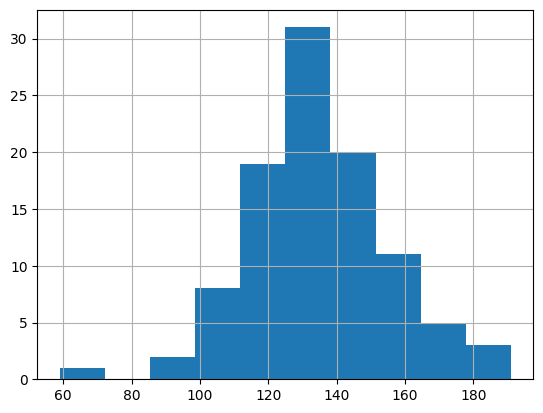

In [14]:
data[data['data set'] == 'train']['labels'].value_counts().hist()

In [15]:
counts = data[data['data set'] == 'train']['labels'].value_counts()
ratio = counts.max() / counts.min()
print(ratio)

3.23728813559322


As we can see in the histogram, we have some cues in class distribution. This means there are some classes with less examples than the rest and the same with more examples. The ideal thing to have is one bar in one of the sizes, in ordet to be equally distributed. As we talked, the ratio between max and min is 3.24, which is pretty high but not severe. TheFor this reason, we will continue without dropping any column for the moment and wait to the augmentation to solve this problem.

## Searching for duplicates

Even though, the project explanation in Kaggle specifies that all duplicate images were removed, we are going to do a basic chack of this. This is an important thing to check because it could help the network to memorize and can cause data leakege if there is duplicate images between traininf and val/test set.

In [19]:
def compute_checksum(file_path):
    hash_md5 = hashlib.md5()
    with open(file_path, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

In [22]:
print(data.shape)

(14493, 4)


In [21]:
# signature_map = defaultdict(list)

# for idx, row in data.iterrows():
#     path = row['filepaths']
#     try:
#         size = os.path.getsize(path)
#         checksum = compute_checksum(path)
#         signature = (size, checksum)
#         signature_map[signature].append(path)

#     except Exception as e:
#         print(f"Error with file {path}: {e}")

In [ ]:
# duplicates = 0
# for paths in signature_map.values():
#     if len(paths) > 1:
#         print("Identical files:")
#         for p in paths:
#             print(f" - {p}")
#         identical_pairs += 1
#         print()
# print(f"Duplicate groups found:{duplicates}")

As it was stated, no duplicated were found doing this basic inspection. THis ensures that it we won't suffer from data leakege.

We will reuse some of the computation to check if there some file has been wrongly encoded or it has any problem.

## Searching for Error files

In [23]:
corrupted_files = []
empty_files = []
for idx, row in data.iterrows():

    path = row["filepaths"]

    size = os.path.getsize(path)
    if size == 0:
        empty_files.append(path)
        continue

    # --- Try to open image to check encoding validity
    try:
        with Image.open(path) as img:
            img.verify()
    except (UnidentifiedImageError, OSError):
        corrupted_files.append(path)
        continue

In [24]:
print(corrupted_files)
print(empty_files)

['train/high jump/159.lnk']
[]


There is one file which is not an .jpg file in the dataset. We can found this on the 'high jump' folder on the train. After inspecting the file, we know that it is a link to the train folder, so we have to remove them from there.

In [25]:
highjumpdir = os.listdir('train/high jump')
len(highjumpdir)
os.remove('train/high jump/159.lnk')
data = data[data["filepaths"] != "train/high jump/159.lnk"]
data.to_csv("sports2.csv", index=False)

In [26]:
highjumpdir2 = os.listdir('train/high jump')
len(highjumpdir2)

158

We have just removed all corrupted files and now data is clean.

## Data Normalization

In [16]:
sample = data.sample(5, random_state=12)
for idx, row in sample.iterrows():
    img_path = row['filepaths']
    img = np.array(Image.open(img_path))
    print(f"Image: {img_path}")
    print(f"  dtype: {img.dtype}, shape: {img.shape}")
    print(f"  min: {img.min()}, max: {img.max()}")
    print(f"  mean per channel: {img.mean(axis=(0,1))}")
    print(f"  std per channel: {img.std(axis=(0,1))}\n")

Image: valid/ice yachting/2.jpg
  dtype: uint8, shape: (224, 224, 3)
  min: 0, max: 255
  mean per channel: [148.13950893 155.4517897  181.13430724]
  std per channel: [58.74903275 56.00626605 43.45235621]

Image: train/giant slalom/016.jpg
  dtype: uint8, shape: (224, 224, 3)
  min: 0, max: 255
  mean per channel: [146.31489158 143.51046317 146.34671955]
  std per channel: [87.37341617 89.76151    89.50728257]

Image: train/rock climbing/002.jpg
  dtype: uint8, shape: (224, 224, 3)
  min: 0, max: 255
  mean per channel: [111.25747369 127.42966757 110.68753986]
  std per channel: [64.47433679 60.1622825  64.74207178]

Image: train/figure skating men/123.jpg
  dtype: uint8, shape: (224, 224, 3)
  min: 4, max: 255
  mean per channel: [216.49208785 221.1080397  216.62549825]
  std per channel: [52.43451692 54.1966991  53.78634786]

Image: train/axe throwing/105.jpg
  dtype: uint8, shape: (224, 224, 3)
  min: 0, max: 255
  mean per channel: [135.02491231 108.23658721  70.73345823]
  std pe

As you can see with this random imaages, mean values of each channel are different depending on the image. THe models we are going to fit on images beneift if ranges are similar. For this reason, we are going to normalize themm right before the training, because if we wanted to sotre them as .jpg we must have to undo the normalization, adn we want to stay like this before the training.

## Class reduction

Before doing the augmentations, we are goiing to reduce our dataset. We want to reduce our number of classes to 50, so by half. The reason beyond that is that we have a lot ofimages which make the training very heavy. For this reason, we think that training to tonly predict 50 classes will make the training easier and will also be a rich study.

We have decided to remove those 50 classes from the ques of distribution of classes. In other words, we have deleted those classes which had the most imgages and also the classes whichh has less images.

In [17]:
train = data[data["data set"] == "train"]
counts = train["labels"].value_counts()
n_classes = len(counts)
n_keep = 50

remove_each_side = (n_classes - n_keep) // 2

counts_df = counts.reset_index()
counts_df.columns = ["label", "count"]

counts_df = counts_df.sort_values(["count", "label"], ascending=[True, True]).reset_index(drop=True)

start = remove_each_side
end = n_classes - remove_each_side
labels_to_keep = counts_df.loc[start:end-1, "label"].tolist()

print("Clases seleccionadas:", len(labels_to_keep))
print(labels_to_keep)

Clases seleccionadas: 50
['hang gliding', 'hammer throw', 'steer wrestling', 'barell racing', 'disc golf', 'bungee jumping', 'trapeze', 'luge', 'figure skating men', 'log rolling', 'tug of war', 'cricket', 'ice climbing', 'shuffleboard', 'ski jumping', 'water polo', 'cheerleading', 'frisbee', 'parallel bar', 'tennis', 'archery', 'jai alai', 'motorcycle racing', 'sidecar racing', 'sumo wrestling', 'croquet', 'fly fishing', 'horse jumping', 'weightlifting', 'fencing', 'track bicycle', 'hurdles', 'javelin', 'speed skating', 'bobsled', 'pole vault', 'horse racing', 'bmx', 'curling', 'rock climbing', 'table tennis', 'surfing', 'volleyball', 'rowing', 'sailboat racing', 'billiards', 'balance beam', 'harness racing', 'snowmobile racing', 'skydiving']


In [18]:
filtered_data = data[data["labels"].isin(labels_to_keep)].copy()
filtered_data.to_csv("sports3.csv", index=False)

<Axes: >

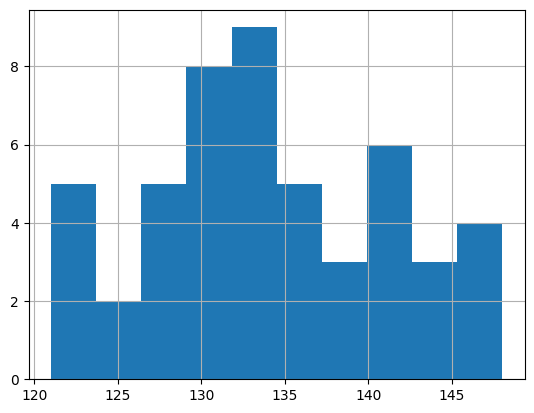

In [20]:
filtered_data[filtered_data['data set'] == 'train']['labels'].value_counts().hist()

This is the distribution after selecting those 50 classes. As we can see, the distribution changed. Now we dont have classes with more than around 150 images and less than 120, while before we had classes od less than 80 or up 180 for example. Now the data is more balanced. However, we will use Data Augmentations to balance it more.

## Data Augmentations

Now we are going to augment our data. This will bw useful for us to have more data and to balance it, as for the moment we have classes with more examples than others. The Augmentations we are going to use are the following:
- Gemoetric Augmentations: Mirror images, few Rotation
- Color Augmentations: brightness, contrast, saturation, hue
- Perspective/Scale
- Noise Augmentation: Gaussian Blur, Motion blur, Gaussian Noise

We have selected those augmentations which could generate real modifications of our images. Geometric augmentations can simualte camera tilt, color augmentations represent stadium lighting for example, the perspective ones simulate camera angle and Noise augmentations introduces noise to the images.

Before deciding which classes to augment, we want to check the datasets distribution and class distribution. 

In [21]:
CountTrain = filtered_data[filtered_data['data set'] == 'train']['labels'].count()
CountVal = filtered_data[filtered_data['data set'] == 'valid']['labels'].count()
CountTest = filtered_data[filtered_data['data set'] == 'test']['labels'].count()
Total = CountTrain + CountVal + CountTest
print(f'Train Size: {CountTrain} -> {CountTrain*100/Total}')
print(f'Val Size: {CountVal} -> {CountVal*100/Total}')
print(f'Test Size: {CountTest} -> {CountTest*100/Total}')

Train Size: 6704 -> 93.05941143808995
Val Size: 250 -> 3.470294280955025
Test Size: 250 -> 3.470294280955025


In [22]:
print(filtered_data[filtered_data['data set'] == 'train']['labels'].value_counts())

labels
skydiving             148
balance beam          147
harness racing        147
snowmobile racing     147
billiards             145
sailboat racing       144
rowing                143
surfing               142
volleyball            142
curling               141
rock climbing         141
table tennis          141
bmx                   140
horse racing          139
bobsled               138
pole vault            138
speed skating         136
hurdles               136
javelin               136
fencing               135
track bicycle         135
croquet               134
weightlifting         134
horse jumping         134
fly fishing           134
sidecar racing        133
sumo wrestling        133
archery               132
jai alai              132
motorcycle racing     132
cheerleading          131
parallel bar          131
tennis                131
frisbee               131
water polo            130
ski jumping           130
ice climbing          130
shuffleboard          130
crick

After seeing this we have made our minds about how to do the augmentations. Our requirements are:
- Augment those classes which have less images to balance the dataset
- Not to do too many augmentations so we dont change a lot data set distributions (we do not want validation and test sets to represent less than 3 %)
- Not to do too many augmentations in oder not to de our training heavier, knowing that our data is already rich and diverse

Knowing this, our following cells takes into account te requirements and calculates which augmentations are going to be performed in which classes in order to satisfy the requirements.

In [42]:
csv_path = "sports3.csv"
labels_col = "labels"
filepath_col = "filepaths"
dataset_col = "data set"

min_valid_pct = 0.03         
percentile_value = 75
fixed_target = 500
max_augment_per_image = 1
save_inplace = True
aug_prefix = "aug_"
seed = 42
random.seed(seed)
np.random.seed(seed)

df = pd.read_csv(csv_path)

total_images = len(df)
val_count = len(df[df[dataset_col].str.lower() == "valid"])
test_count = len(df[df[dataset_col].str.lower() == "test"])
train_df = df[df[dataset_col].str.lower() == "train"]
train_total = len(train_df)

max_total_from_val = math.floor(val_count / min_valid_pct)
max_total_from_test = math.floor(test_count / min_valid_pct)
max_new_images = min(max_total_from_val, max_total_from_test) - total_images
max_new_images = max(0, int(max_new_images))
print(f"Actual Distribution: {total_images}, train: {train_total}, val: {val_count}, test: {test_count}")
print(f"Maximum number of new images permitted (without lowing val/test < {min_valid_pct*100:.1f}%): {max_new_images}")

counts = train_df[labels_col].value_counts().sort_values()
n_classes = len(counts)
print(f"Classes (train): {n_classes}, range: {counts.min()} - {counts.max()}")

target = int(np.median(counts.values))
print(f"Target per class: {target}")

needs = (target - counts).clip(lower=0)
needs = needs[needs > 0].sort_values()
total_needed = int(needs.sum())
print(f"Total images needes: {total_needed}")

alloc = {}
remaining = max_new_images
if total_needed <= remaining:
    for lbl, nm in needs.items():
        alloc[lbl] = int(nm)
else:
    for lbl, nm in needs.items():
        if remaining <= 0:
            alloc[lbl] = 0
            continue
        take = min(int(nm), remaining)
        alloc[lbl] = int(take)
        remaining -= take

allocated_total = sum(alloc.values())
print(f"Total assignated to generate: {allocated_total} (of max {max_new_images})")
for lbl, nm in sorted(alloc.items(), key=lambda x: x[1], reverse=False):
    if nm>0:
        print(f"  {lbl}: +{nm}")

allocation = alloc

Actual Distribution: 7204, train: 6704, val: 250, test: 250
Maximum number of new images permitted (without lowing val/test < 3.0%): 1129
Classes (train): 50, range: 121 - 148
Target per class: 133
Total images needes: 118
Total assignated to generate: 118 (of max 1129)
  archery: +1
  jai alai: +1
  motorcycle racing: +1
  cheerleading: +2
  frisbee: +2
  parallel bar: +2
  tennis: +2
  ski jumping: +3
  shuffleboard: +3
  water polo: +3
  ice climbing: +3
  cricket: +4
  log rolling: +5
  figure skating men: +5
  tug of war: +5
  luge: +6
  bungee jumping: +8
  trapeze: +8
  barell racing: +10
  disc golf: +10
  hammer throw: +11
  steer wrestling: +11
  hang gliding: +12


Here is printed the total number of augmentations that are going to be performed: 118. This is number is not so high to satisfy our requirments. Also there is the number of augmented images per class that is going to be created. In the following cell, the augmented files are created, changing as well the csv.

In [47]:
def random_transform(img):
    tf = random.choice([
        lambda x: F.hflip(x),
        lambda x: F.rotate(x, 15),
        lambda x: F.adjust_brightness(x, 1 + random.uniform(-0.2, 0.2)),
        lambda x: F.adjust_contrast(x, 1 + random.uniform(-0.2, 0.2)),
        lambda x: F.adjust_saturation(x, 1 + random.uniform(-0.2, 0.2))
    ])
    return tf(img)

train_df = df[df[dataset_col].str.lower() == "train"]

new_rows = []
generated = 0

aug_counter = {}

for label, to_create in tqdm(sorted(allocation.items(), key=lambda x: x[1], reverse=True)):
    if to_create <= 0:
        continue

    # clearer name
    image_paths = train_df[train_df[labels_col] == label][filepath_col].tolist()

    if not image_paths:
        print(f"Warning: no files for class '{label}'")
        continue

    random.shuffle(image_paths)
    idx = 0

    while to_create > 0 and idx < len(image_paths):
        src = image_paths[idx]
        idx += 1

        if src not in aug_counter:
            aug_counter[src] = 0

        gen_from_this = min(max_augment_per_image, to_create)

        for _ in range(gen_from_this):

            aug_counter[src] += 1
            num = aug_counter[src]

            base_dir = os.path.dirname(src) or "."
            orig_name = os.path.splitext(os.path.basename(src))[0]

            out_path = base_dir.replace("\\", "/") + f"/{orig_name}_{aug_prefix}{num}.jpg"

            os.makedirs(os.path.dirname(out_path), exist_ok=True)
            
            img = Image.open(src).convert("RGB")

            out_img = random_transform(img)
            out_img.save(out_path, quality=95)

            new_rows.append({
                labels_col: label,
                filepath_col: out_path,
                dataset_col: "train",
            })
            to_create -= 1
            generated += 1
            if to_create <= 0:
                break

if generated:
    display(pd.DataFrame(new_rows).head(10))

if new_rows:
    new_df = pd.DataFrame(new_rows)
    
    df_subset = df[new_df.columns.intersection(df.columns)]
    
    full = pd.concat([df_subset, new_df], ignore_index=True)
    
    out_csv = "sports4.csv"
    full.to_csv(out_csv, index=False)
    print(f"CSV updated in: {out_csv}")



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  6.22it/s]


,labels,filepaths,data set
0,hang gliding,train/hang gliding/078_aug_1.jpg,train
1,hang gliding,train/hang gliding/075_aug_1.jpg,train
2,hang gliding,train/hang gliding/060_aug_1.jpg,train
3,hang gliding,train/hang gliding/058_aug_1.jpg,train
4,hang gliding,train/hang gliding/039_aug_1.jpg,train
5,hang gliding,train/hang gliding/059_aug_1.jpg,train
6,hang gliding,train/hang gliding/068_aug_1.jpg,train
7,hang gliding,train/hang gliding/076_aug_1.jpg,train
8,hang gliding,train/hang gliding/019_aug_1.jpg,train
9,hang gliding,train/hang gliding/077_aug_1.jpg,train


CSV updated in: sports4.csv


In [49]:
filtered_data = pd.read_csv('sports4.csv')
CountTrain = filtered_data[filtered_data['data set'] == 'train']['labels'].count()
CountVal = filtered_data[filtered_data['data set'] == 'valid']['labels'].count()
CountTest = filtered_data[filtered_data['data set'] == 'test']['labels'].count()
Total = CountTrain + CountVal + CountTest
print(f'Train Size: {CountTrain} -> {CountTrain*100/Total}')
print(f'Val Size: {CountVal} -> {CountVal*100/Total}')
print(f'Test Size: {CountTest} -> {CountTest*100/Total}')

Train Size: 6822 -> 93.17126468178094
Val Size: 250 -> 3.414367659109533
Test Size: 250 -> 3.414367659109533


Here we can see the final distribution. The distribution has not change so much (from 3.47 in val and test to 3.41). This is great for us taking into account the requirements.

<Axes: >

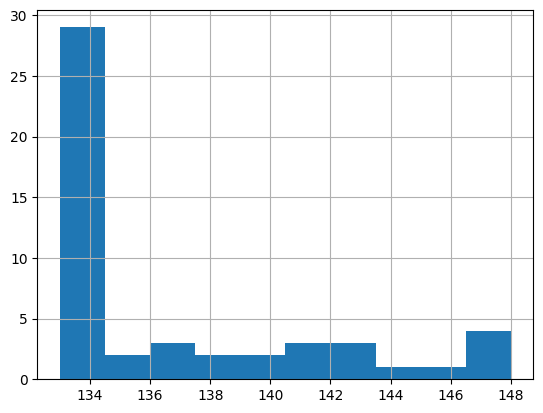

In [50]:
filtered_data[filtered_data['data set'] == 'train']['labels'].value_counts().hist()

This is the final distribution of classes that we are going to use for the neural network. As we can see, the data augmentation has succesfully balanced data, making most of tha classes size 134, while there are few others with more (and not much more, maximum 15 images more).